# User Profile Data Prep

This notebook does the data preparation for Bayesian inference for the model analysis.

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan

In [2]:
variable = 'gender'

## Load Data

We need to load the author-gender information:

In [3]:
book_gender = pd.read_csv('data/author-gender.csv.gz')
book_gender = book_gender.set_index('item')['gender']
book_gender.describe()

count     10735373
unique           6
top           male
freq       3245842
Name: gender, dtype: object

In [4]:
book_gender[book_gender == 'no-viaf-author'] = 'unlinked'
book_gender[book_gender == 'no-loc-author'] = 'unlinked'
book_gender[book_gender == 'no-loc-book'] = 'unlinked'
book_gender = book_gender.astype('category')
book_gender.unique()

[unknown, unlinked, female, male, ambiguous]
Categories (5, object): [unknown, unlinked, female, male, ambiguous]

And we load book hashes, to set up our dummy bias:

In [5]:
book_hash = pd.read_parquet('data/book-hash.parquet').rename(columns={'cluster': 'item'})
book_hash['dcode'] = book_hash['md5'].apply(lambda x: int(x[-1], 16) % 2)
book_hash = book_hash.set_index('item')
book_hash.head()

/home/mekstrand/miniconda2/envs/bookfair/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/mekstrand/miniconda2/envs/bookfair/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/mekstrand/miniconda2/envs/bookfair/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,nisbns,md5,dcode
item,,,
100000001,2,b6797168fc729b01cac4ea70ffeeb66b,1
100000002,2,a4085a8051976573c2b51d5f87d2f1d3,1
100000003,2,829f0158d2f4328e5d034ef88282f8bc,0
100000004,5,699786577b6425c7d565d1394f794a70,0
100000005,2,d0e89179cb36957e032c7884b3df4fd9,1


Load the sample user ratings for each data set:

In [6]:
user_ratings = pd.read_csv('data/study-ratings.csv')
user_ratings.drop(columns=['rating'], inplace=True)
user_ratings.rename(columns={'dataset': 'Set'}, inplace=True)
user_ratings.head()

,Set,user,item,first_time,last_time,nactions,timestamp
0,AZ,5670400,101873593,NaN,NaN,NaN,1.369526e+09
1,AZ,5670400,102121678,NaN,NaN,NaN,1.380413e+09
2,AZ,5670400,102779907,NaN,NaN,NaN,1.339632e+09
3,AZ,5670400,102906342,NaN,NaN,NaN,1.353629e+09
4,AZ,5670400,103238152,NaN,NaN,NaN,1.371341e+09


In [7]:
user_ratings = user_ratings.join(book_gender, on='item', how='left')
user_ratings['gender'].fillna('unlinked', inplace=True)
user_ratings = user_ratings.join(book_hash['dcode'], on='item', how='left')
user_ratings.head(15)

,Set,user,item,first_time,last_time,nactions,timestamp,gender,dcode
0,AZ,5670400,101873593,NaN,NaN,NaN,1.369526e+09,female,NaN
1,AZ,5670400,102121678,NaN,NaN,NaN,1.380413e+09,male,NaN
2,AZ,5670400,102779907,NaN,NaN,NaN,1.339632e+09,female,NaN
3,AZ,5670400,102906342,NaN,NaN,NaN,1.353629e+09,female,0.0
4,AZ,5670400,103238152,NaN,NaN,NaN,1.371341e+09,female,NaN
5,AZ,5670400,105031321,NaN,NaN,NaN,1.371341e+09,male,0.0
6,AZ,5670400,105469180,NaN,NaN,NaN,1.361664e+09,male,0.0
7,AZ,5670400,108871645,NaN,NaN,NaN,1.363738e+09,male,1.0
8,AZ,5670400,111518119,NaN,NaN,NaN,1.371341e+09,ambiguous,0.0
9,AZ,5670400,111838236,NaN,NaN,NaN,1.361664e+09,unlinked,NaN


Now we will summarize user profiles:

In [8]:
def summarize_profile(df):
    gender = df['gender']
    dc = df['dcode']
    data = {
        'count': len(df),
        'linked': np.sum(gender != 'unlinked'),
        'ambiguous': np.sum(gender == 'ambiguous'),
        'male': np.sum(gender == 'male'),
        'female': np.sum(gender == 'female'),
        'dcknown': dc.count(),
        'dcyes': dc.sum(skipna=True),
        'PropDC': dc.mean()
    }
    data['Known'] = data['male'] + data['female']
    data['PropFemale'] = data['female'] / data['Known']
    data['PropKnown'] = data['Known'] / data['count']
    return pd.Series(data)

In [9]:
profiles = user_ratings.groupby(['Set', 'user']).apply(summarize_profile)
profiles = profiles.apply(lambda s: s if s.name.startswith('Prop') else s.astype('i4'))
profiles.head()

count  linked  ambiguous  male  female  dcknown  dcyes    PropDC  \
Set user                                                                      
AZ  34891     26       6          0     0       5        3      1  0.333333   
    35841      7       7          1     0       5        3      3  1.000000   
    39018     17      10          1     3       5        7      3  0.428571   
    52563      8       8          0     0       8        4      2  0.500000   
    60825     45      38          0    31       7       18     11  0.611111   

           Known  PropFemale  PropKnown  
Set user                                 
AZ  34891      5    1.000000   0.192308  
    35841      5    1.000000   0.714286  
    39018      8    0.625000   0.470588  
    52563      8    1.000000   1.000000  
    60825     38    0.184211   0.844444

How are profile sizes distributed?

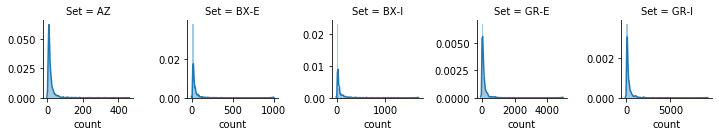

In [10]:
g = sns.FacetGrid(profiles.reset_index(), col='Set', sharex=False, sharey=False, height=2)
g.map(sns.distplot, 'count')
plt.savefig('figures/profile-size-all.pdf')

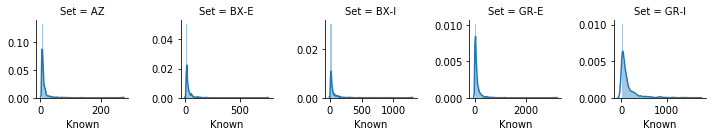

In [11]:
g = sns.FacetGrid(profiles.reset_index(), col='Set', sharex=False, sharey=False, height=2)
g.map(sns.distplot, 'Known')
plt.savefig('figures/profile-size-known.pdf')

And % known?

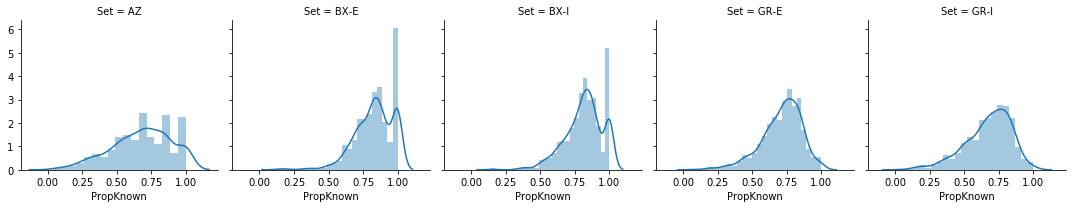

In [12]:
g = sns.FacetGrid(profiles.reset_index(), col='Set')
g.map(sns.distplot, 'PropKnown')

## Distribution of Female Authors

Quick empirical inspection:

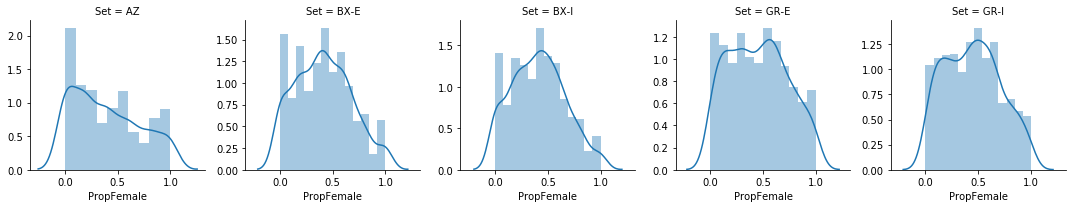

In [13]:
g = sns.FacetGrid(profiles.reset_index(), col='Set', sharey=False)
g.map(sns.distplot, 'PropFemale')

In [14]:
profiles.groupby('Set')['PropFemale'].mean()

Set
AZ      0.394471
BX-E    0.412705
BX-I    0.410818
GR-E    0.453435
GR-I    0.448197
Name: PropFemale, dtype: float64

In [15]:
np.sqrt(profiles.groupby('Set')['PropFemale'].var())

Set
AZ      0.319049
BX-E    0.265400
BX-I    0.253278
GR-E    0.278924
GR-I    0.264529
Name: PropFemale, dtype: float64

## Distribution of Dummy Codes

Quick empirical inspection - this should be noise:

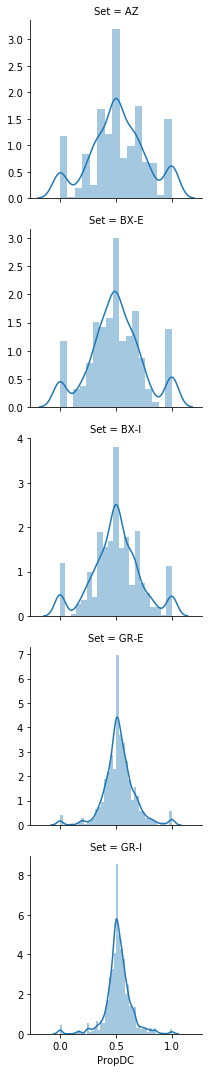

In [16]:
g = sns.FacetGrid(profiles.reset_index(), row='Set', sharey=False)
g.map(sns.distplot, 'PropDC')

## Saving Outputs

We save profile data frame to be reloaded in the Bayesian analysis.

In [17]:
profiles.to_pickle('data/profile-data.pkl')